(vqc)=

# Вариационные квантовые схемы

## Описание лекции

На этой лекции мы впервые познакомимся с непосредственно квантовым машинным обучением. Теперь, вместо `NumPy` мы будем использовать `PennyLane`. Лекция включает следующие темы:

- В чем идея квантово-классического обучения?
- Что такое вариационное машинное обучение?
- Как устроена вариационная квантовая схема?
- Как можно закодировать данные в вариационную схему?

## Введение

Далее, в течение всего курса, мы будем больше всего говорить о квантово-классическом машинном обучении, которое построено на базе вариационных квантовых схем. Именно этот тип комбинированного, квантово-классического машинного обучения является наиболее перспективным в NISQ-эру. Прежде, чем мы начнем, давайте заглянем немного вперед и посмотрим, как выглядит типичный цикл такого обучения.

```{figure} /_static/vqcblock/vqc/diagram.png
:name: vqcdiag
:height: 400px

Пример цикла смешанного обучения
```

Красным цветом на этой диаграмме помечены блоки, которые выполняются на квантовом устройстве, а зеленым -- то, что считается на обычном компьютере. Квантовая часть, которая включает в себя операторы $\hat{U(X)}$ и $\hat{U(\theta})$, а также измерение наблюдаемой $\hat{M}$ как раз и называется вариационной квантовой схемой, и именно ей мы посвятим сегодняшнее занятие.

Но сначала нам придется сделать шаг назад и обсудить в общих чертах идеи, которые лежат в основе квантово-классического обучения.

## Квантово-классическое обучение

Основная идея, которая лежит в основе квантово-классического обучения заключается в том, что в Noise Intermediate Scale Quantum (_NISQ_) эпоху у нас нет больших работающих квантовых компьютеров и нет квантовой памяти. Это сильно ограничивает нас в применении алгоритмов, которые дают нам гарантированное ускорение над их классическими аналогами. Практически, все что нам остается -- это "встраивать" квантовые схемы в классический цикл обучения.

В этом случае обычно мы разделяем классическую и квантовую части алгоритма. Мы выполняем предварительную обработку и подготовку данных на классическом компьютере, после чего "прогоняем" их через квантовую схему. Эта схема должна возвращать нам классические данные, а значит, включает в себя набор последовательно применяемых операторов и измерение. В этом случае, со стороны классического компьютера, такая схема будет выглядеть как просто некий "черный ящик" или "оракул", с которым уже можно работать. Например, можно варьировать параметры схемы таким образом, чтобы она "обучалась" так же, как "обучаются" нейронные сети или другие алгоритмы классического машинного обучения.

Давайте более детально посмотрим на квантовую схему, которая может быть использована в таком подходе.

## Вариационные квантовые схемы

В основе вариационных квантовых схем, или Variational Quantum Circuits (**VQC**) лежит достаточно простая идея. Давайте сделаем схему, которая включает в себя набор унитарных операторов и переводит классические данные $\mathbf{X}$ и параметры $\theta$ в квантовое состояние $\ket{\Psi}(\theta, \mathbf{X})$. А дальше, давайте /варьировать/ наше состояние $\ket{\Psi}$, меняя параметры $\theta$ так, чтобы при его измерении в каком-либо базисе мы получали нужный нам результат, например, результат классификации входных данных $\mathbf{X}$.

Давайте разберем это на простом примере.

### Аппроксимация матрицы Паули **X** оператором поворота

Как мы помним из предыдущих лекций, оператор $\hat{\mathbf{X}}$ работает как квантовый аналог оператора =NOT= -- он инвертирует значение кубита.

In [1]:
import pennylane as qml

dev = qml.device("default.qubit", 1)

@qml.qnode(dev)
def simple_x_gate():
    qml.PauliX(0)
    return qml.expval(qml.PauliZ(0))


print(simple_x_gate())

print(simple_x_gate.draw())

-1.0
 0: ──X──┤ ⟨Z⟩ 



```{note}
Тут мы измеряем наш кубит в $\mathbf{Z}$-базисе и чаще всего иы будем измерять именно в нем. $\mathbf{Z}$-базис является неким "стандартом" для квантовых вычислений, так как это измерение "ближе к железу".
```

С другой стороны, у нас есть оператор $\hat{RX}(\phi)$, который "вращает" состояние нашего кубита вокруг оси $\mathbf{X}$ на угол $\phi$. Давайте сделаем параметризованную схему с одним параметром:

In [2]:
@qml.qnode(dev)
def vqc(phi):
    qml.RX(phi, wires=[0])
    return qml.expval(qml.PauliZ(0))

Теперь давайте попробуем подобрать $\phi$ так, чтобы наша параметризованная схема работала точно так же, как оператор $\hat{X}$:

In [3]:
print(f"Try 1.0: {vqc(0)}")
print(f"Try 2.0: {vqc(2)}")
print(f"Try 3.0: {vqc(3)}")
print(f"Try 3.14159265359: {vqc(3.14159265359)}")

Try 1.0: 1.0
Try 2.0: -0.4161468365471423
Try 3.0: -0.9899924966004454
Try 3.14159265359: -1.0


Мы получили, что нужный нам угол $\phi$ составляет ровно $\pi$. Это логично, и мы могли бы это легко понять из простейших соображений линейной алгебры, либо даже взглянув на сферу Блоха. Но целью этого примера для нас было /почувствовать/ как работают VQC.

Понятно, что наш процесс "подбора" параметра $\phi$ крайне примитивный, но следующую лекцию мы полностью посвятим тому, как можно посчитать градиент параметров квантовой схемы и задействовать всю мощь изобретенных на сегодня методов оптимизации. А пока давайте еще раз подумаем о том, как можно закодировать данные в квантовую схему.

## Как можно закодировать данные в VQC

Как можно было заметить, в конструировании VQC есть две важных части:

- Кодирование классических данных в квантовые операторы
- Выбор наблюдаемой для измерений

Давайте посмотрим, как можно закодировать данные в схему.

### Кодирование поворотами

Один из самых популярных методов кодирования классических данных в квантовые схемы -- это использование операторов поворота $\hat{RY}, \hat{RZ}$. Представим, что мы хотим отображать вектор из двухмерного пространства в один кубит $\vec{x} \in \mathbb{R}^2 \to \mathbb{C}^2$.

In [4]:
@qml.qnode(dev)
def angle_vqc(a, b):
    qml.RY(a, wires=[0])
    qml.RZ(b, wires=[0])

    return qml.expval(qml.PauliZ(0))

А теперь давайте посмотрим, как такая схема преобразует данные. Для этого сгенерируем набор случайных двухмерных данных в диапазоне $[0, 2\pi]$ и применим к каждой точке нашу схему, после чего визуализируем результаты:

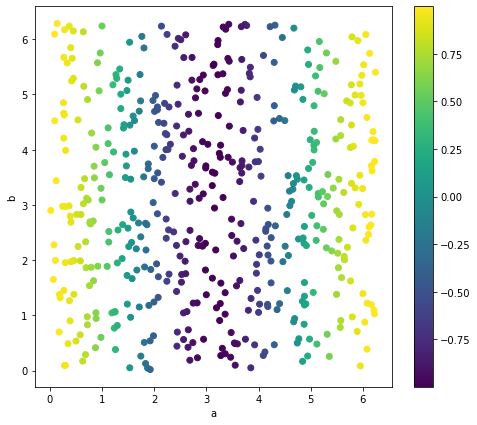

In [5]:
import numpy as np
import matplotlib.pyplot as plt

aa = np.random.uniform(0, 2 * np.pi, size=500)
bb = np.random.uniform(0, 2 * np.pi, size=500)

res = [angle_vqc(a, b) for a, b in zip(aa, bb)]

f = plt.figure(figsize=(8, 7))
clb = plt.scatter(aa, bb, c=res)
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(clb)

f.show()

Результат довольно необычный -- предсказать такое довольно сложно и хорошо видна возможность нелинейности `VQC` схем. В дальнейших лекциях мы будем более подробно разбирать возможные варианты кодирования данных. Кстати, кодирование углами настолько популярно, что в `PennyLane` для этого есть специальная функция, которая позволяет "повернуть" сразу множество кубитов, используя список из классических данных:

In [6]:
@qml.qnode(dev)
def angle_vqc_pl(a, b):
    qml.templates.embeddings.AngleEmbedding([a], wires=[0], rotation="Y")
    qml.templates.embeddings.AngleEmbedding([b], wires=[0], rotation="Z")
    return qml.expval(qml.PauliZ(0))

Давайте убедимся, что это даст нам ровно тот же результат:

In [7]:
res_pl = [angle_vqc_pl(a, b) for a, b in zip(aa, bb)]
print(np.allclose(res, res_pl))

True


### Важность многокубитных гейтов

Очень хорошая идея при кодировании параметров -- использовать многокубитные гейты, так как именно они создают запутанные состояния и раскрывают все преимущества квантовых компьютеров! Давайте попробуем это сделать.

In [8]:
dev2 = qml.device("default.qubit", 2)

@qml.qnode(dev2)
def cnot_vqc(a, b):
    qml.RY(a, wires=0)
    qml.RY(b, wires=1)
    qml.RZ(a, wires=0)
    qml.RZ(b, wires=1)
    qml.CZ(wires=[0, 1])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

В этой схеме мы видим оператор $\hat{CZ}$, который как раз и создает нам запутанное состояние. Давайте посмотрим, как такая схема преобразует наше исходное пространство случайных точек.

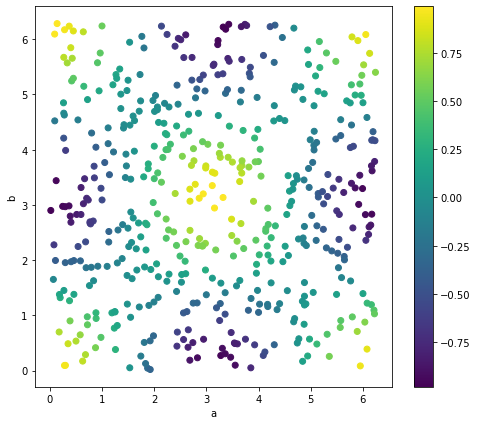

In [9]:
res = [cnot_vqc(a, b) for a, b in zip(aa, bb)]

f = plt.figure(figsize=(8, 7))
clb = plt.scatter(aa, bb, c=res)
plt.xlabel("a")
plt.ylabel("b")
plt.colorbar(clb)

plt.show()

Можно заметить, что результат выглядит гораздо интереснее. В целом можно сказать, что кодирование данных является одним из важнейших выборов при проектировании **VQC**, и мы еще много будем обсуждать различные способы того, как это можно сделать.

## Что мы узнали из этой лекции

Давайте кратко повторим, что мы узнали из этой лекции:

- В NISQ эпоху мы чаще всего ограничены комбинированием квантового и классического машинного обучения
- Ключевой элемент такого обучения -- вариационные квантовые схемы (VQC)
- Основная идея VQC:
  - Кодируем классические данные в квантовые операторы
  - Измеряем состояние
  - Варьируем параметры на классическом компьютере так, чтобы измерение давало желаемый результат
- Один из широко применимых методов кодирования -- это использование операторов вращений $\hat{RX}, \hat{RY}, \hat{RZ}$